In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [20]:
import datetime as dt
from sqlalchemy import create_engine, inspect

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table

measurment = Base.classes.measurement
station = Base.classes.station

In [10]:
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
first_row = session.query(measurment).first()
first_row.__dict__



{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f8b682d0400>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [23]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f8ba8467790>,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716}

In [ ]:
max_date = session.query(func.max(measurment.date)).first()
twelve_months_prior = dt.datetime.strptime(max_date[0],"%Y-%m-%d") - dt.timedelta(days=365)

In [51]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

query_results = session.query(func.sum(measurment.prcp), measurment.date).\
                    group_by(measurment.date).\
                    filter(measurment.date >= twelve_months_prior).\
                    order_by(measurment.date)

last_12_months_df = pd.DataFrame(query_results, columns=["Precip", "Date"])
last_12_months_df

,Precip,Date
0,9.33,2016-08-24
1,0.54,2016-08-25
2,0.10,2016-08-26
3,0.32,2016-08-27
4,3.10,2016-08-28
...,...,...
360,0.09,2017-08-19
361,0.01,2017-08-20
362,0.58,2017-08-21
363,0.50,2017-08-22


Text(0, 0.5, 'Precipitation (in)')

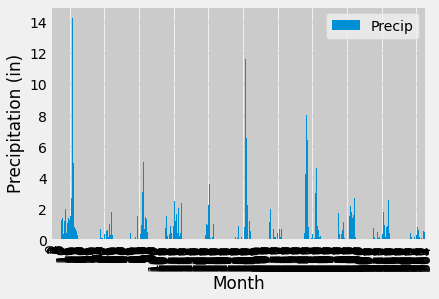

In [54]:
last_12_months_df.plot.bar()
plt.xlabel("Month")
plt.ylabel("Precipitation (in)")

In [44]:
# Calculate the date 1 year ago from the last data point in the database
max_date

('2017-08-23')

In [69]:
query_results_again = session.query(measurment.prcp, measurment.date).\
                        filter(measurment.date >= twelve_months_prior).\
                        order_by(measurment.date)


In [71]:
query_results_new_df_again = pd.DataFrame(query_results_again, columns=["Precipitation", "Date"])

In [72]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_results_new_df_again.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [80]:
# Design a query to show how many stations are available in this dataset?
for row in stations:
    print(row.station)


USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


In [95]:
# What are the most active stations? (i.e. what stations have the most rows)?

station_results = session.query(measurment.station,func.count(measurment.station)).\
                    group_by(measurment.station).\
                    order_by(func.count(measurment.station).desc())

# List the stations and the counts in descending order.
for row in station_results: 
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [140]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

active_station = session.query(measurment.station,func.count(measurment.station)).\
                    group_by(measurment.station).\
                    order_by(func.count(measurment.station).desc()).first()
    
max_temp = session.query(measurment.station, func.max(measurment.tobs)).\
               filter(measurment.station == active_station[0])
min_temp = session.query(measurment.station, func.min(measurment.tobs)).\
               filter(measurment.station == active_station[0])              

avg_temp = session.query(measurment.station, func.avg(measurment.tobs)).\
               filter(measurment.station == active_station[0])  



for row in max_temp:
    print(row)
for row in min_temp: 
    print(row)
for row in avg_temp: 
    print(row)

('USC00519281', 85.0)
('USC00519281', 54.0)
('USC00519281', 71.66378066378067)


In [136]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query_active_station = session.query(func.sum(measurment.tobs), measurment.date).\
                    group_by(measurment.date).\
                    filter(measurment.date >= twelve_months_prior, measurment.station == active_station[0]).\
                    order_by(measurment.date)

active_station_df = pd.DataFrame(query_active_station, columns=["Precip", "Date"])
active_station_df



,Precip,Date
0,77.0,2016-08-24
1,80.0,2016-08-25
2,80.0,2016-08-26
3,75.0,2016-08-27
4,73.0,2016-08-28
...,...,...
346,77.0,2017-08-14
347,77.0,2017-08-15
348,76.0,2017-08-16
349,76.0,2017-08-17


Text(0.5, 1.0, 'Precipitation frequency for Station USC00519281')

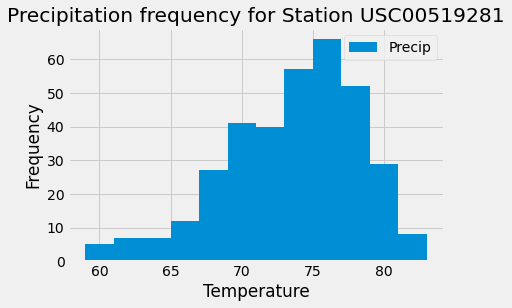

In [157]:
active_station_df.plot.hist(bins=12, alpha = 1)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Precipitation frequency for Station USC00519281")



## Bonus Challenge Assignment

In [151]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [149]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [150]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
]==]{{{{{{{{# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
